# Response Spectra

In [9]:
import glob, os
from obspy import read, Stream
from obspy.core.trace import Stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
%matplotlib inline 

### Get list of the folders

In [2]:
cwd = os.getcwd()

In [3]:
dirs = [ name for name in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), name)) ]

### Remove unnecessary folder

In [4]:
dirs.remove('.ipynb_checkpoints')

### Get the list of the files inside in a folder

In [5]:
sacs = glob.glob(dirs[0] + '/*')

## Read all sac files 

In [6]:
st_org = Stream()
for sac in sacs:
    st_org += read(sac,format='SAC')

In [7]:
from scipy.linalg import expm
from numpy.linalg import pinv

In [10]:
def ins_resp(data, dt,periods = np.linspace(0.01,10.0,num = 100), xi = 0.05):
  '''  
  The function generates pseudo-spectral acceleration (PSA), pseudo-spectral velocity (PSV) and spectral displacement (SD) spectra for given damping ratio (xi).
  Spectral ordinates are for linear-elastic single-degree-of-freedom system with unit mass. 
  
  
  Reference:
  Wang, L.J. (1996). Processing of near-field earthquake accelerograms: Pasadena, California Institute of Technology.
  
  This code is converted from Matlab code of Dr. Erol Kalkan, P.E.
  Link:
  https://www.mathworks.com/matlabcentral/fileexchange/57906-pseudo-spectral-acceleration--velocity-and-displacement-spectra?s_tid=prof_contriblnk
  
      INPUTS
      
  data    = numpy array type object (in acceleration (cm/s^2))
  dt      = sampling rate
  periods = spectral periods (Default: 0.01 to 10 seconds with 100 sample)
  xi      = damping factor (Default: 0.05)
  
      OUTPUTS
      
  PSA = Pseudo-spectral acceleration ordinates
  PSV = Pseudo-spectral velocity ordinates
  SD  = spectral displacement ordinates
  
  REQUIREMENTS:
  scipy, numpy, os, matplotlib
  '''
  
  A = [];Ae = [];AeB = [];  
  displ_max = np.empty((len(periods)))
  veloc_max = np.empty((len(periods)))
  absacc_max = np.empty((len(periods)))
  foverm_max = np.empty((len(periods)))
  pseudo_acc_max = np.empty((len(periods)))
  pseudo_veloc_max = np.empty((len(periods)))
  PSA = np.empty((len(periods)))
  PSV = np.empty((len(periods)))
  SD = np.empty((len(periods)))
  
  acc = data
  #vel = data[0].integrate(method='cumtrapz')
  #dist = data[0].integrate(method='cumtrapz')
  
  ''' Spectral solution '''
  
  for num,val in enumerate(periods):
    omegan = 2*np.pi/val # Angular frequency
    C = 2*xi*omegan # Two time of critical damping and angular freq.
    K = omegan**2
    y = np.zeros((2,len(acc)))
    A = np.array([[0, 1], [-K, -C]])
    Ae = expm(A*dt)
    temp_1 = Ae-np.eye(2, dtype=int)
    temp_2 = np.dot(Ae-np.eye(2, dtype=int),pinv(A))
    AeB = np.dot(temp_2,np.array([[0.0],[1.0]]))

    for k in np.arange(1,len(acc)):
      y[:,k] = np.reshape(np.add(np.reshape(np.dot(Ae,y[:,k-1]),(2,1)), np.dot(AeB,acc[k])),(2))

    displ = np.transpose(y[0,:])	# Relative displacement vector (cm)
    veloc = np.transpose(y[1,:])	# Relative velocity (cm/s)
    foverm = (omegan**2)*displ		# Lateral resisting force over mass (cm/s2)
    absacc = -2*xi*omegan*veloc-foverm	# Absolute acceleration from equilibrium (cm/s2)
    
    ''' Extract peak values '''
    displ_max[num] = max(abs(displ))	# Spectral relative displacement (cm)
    veloc_max[num] = max(abs(veloc))	# Spectral relative velocity (cm/s)
    absacc_max[num] = max(abs(absacc))	# Spectral absolute acceleration (cm/s2)

    foverm_max[num] = max(abs(foverm))			# Spectral value of lateral resisting force over mass (cm/s2)
    pseudo_acc_max[num] = displ_max[num]*omegan**2	# Pseudo spectral acceleration (cm/s2)
    pseudo_veloc_max[num] = displ_max[num]*omegan	# Pseudo spectral velocity (cm/s)
    
    PSA[num] = pseudo_acc_max[num]	# PSA (cm/s2)
    PSV[num] = pseudo_veloc_max[num]	# PSV (cm/s)
    SD[num] = displ_max[num]		# SD  (cm)
    
    
  return PSA, PSV, SD

def plotting(PSA,PSV,SD,periods,saving, logplot = True, title = False):
  fig = plt.figure()
  ax1 = fig.add_subplot(311)
  ax2 = fig.add_subplot(312)
  ax3 = fig.add_subplot(313)
  
  if logplot:
    ax1.loglog(periods,PSA)
    ax2.loglog(periods,PSV)
    ax3.loglog(periods,SD)
  else:
    ax1.plot(periods,PSA)
    ax2.plot(periods,PSV)
    ax3.plot(periods,SD)
    
  ax1.grid(True)
  ax2.grid(True)
  ax3.grid(True)
  
  if title:
    ax1.set_title(title + '\n' + 'Pseudo spectral acceleration ($\mathregular{cm/s^{2}}$)')
  else:  
    ax1.set_title('Pseudo spectral acceleration ($\mathregular{cm/s^{2}}$)')
  ax2.set_title('Pseudo spectral velocity (cm/s)')
  ax3.set_title('Spectral displacement (cm)')
  
  ax1.set_ylabel('Amplitude', ha='center', va='center', rotation='vertical')
  ax2.set_ylabel('Amplitude', ha='center', va='center', rotation='vertical')
  ax3.set_ylabel('Amplitude', ha='center', va='center', rotation='vertical')
  
  # Set common labels
  fig.text(0.5, 0.01, 'Periods (s)', ha='center', va='center')
  #fig.text(0.015, 0.5, 'Amplitude ($\mathregular{cm/s^{2}}$)', ha='center', va='center', rotation='vertical')
  
  plt.tight_layout()
  
  if saving == 'show':
    plt.show()
  elif saving == 'save':
    cwd = os.getcwd()
    if title:
      plt.savefig(cwd + '/' + title + '_' + 'spectra.png', dpi=300)
    else:
      plt.savefig(cwd  + '/' + 'spectra.png', dpi=300)
  elif saving == 'show_save':
    cwd = os.getcwd()
    if title:
      plt.savefig(cwd + '/' + title + '_' + 'spectra.png', dpi=300)
    else:
      plt.savefig(cwd  + '/' + 'spectra.png', dpi=300)
    plt.show()

Spectral Periods

In [11]:
sPeriod = np.array([0.01,0.02,0.022,0.025,0.029,0.03,0.032,0.035,0.036,
  0.04,0.042,0.044,0.045,0.046,0.048,0.05,0.055,0.06,0.065,0.067,0.07,
  0.075,0.08,0.085,0.09,0.095,0.1,0.11,0.12,0.125,0.13,0.133,0.14,0.15,
  0.16,0.17,0.18,0.19,0.2,0.22,0.24,0.25,0.26,0.28,0.29,0.3,0.32,0.34,
  0.35,0.36,0.38,0.4,0.42,0.44,0.45,0.46,0.48,0.5,0.55,0.6,0.65,0.667,
  0.7,0.75,0.8,0.85,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,
  2,2.2,2.4,2.5,2.6,2.8,3,3.2,3.4,3.5,3.6,3.8,4,4.2,4.4,4.6,4.8,5,7.5,
  10])

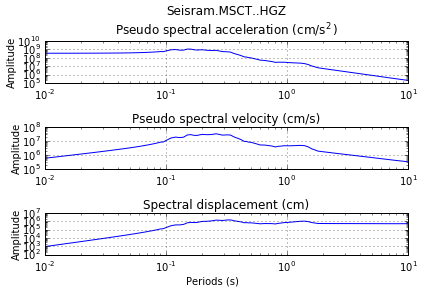

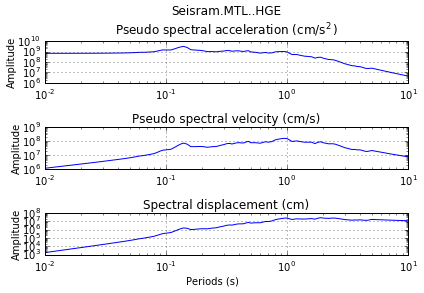

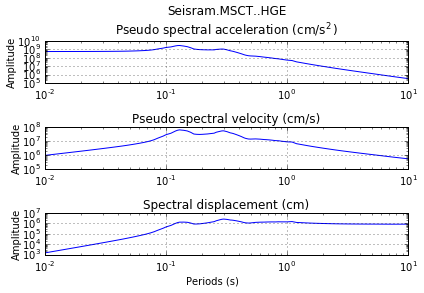

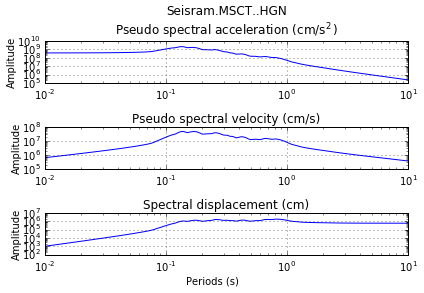

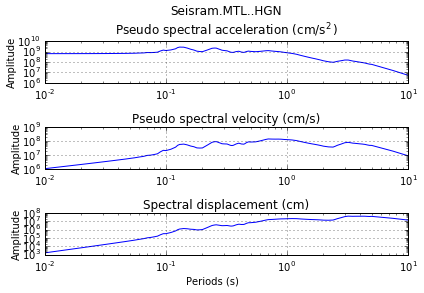

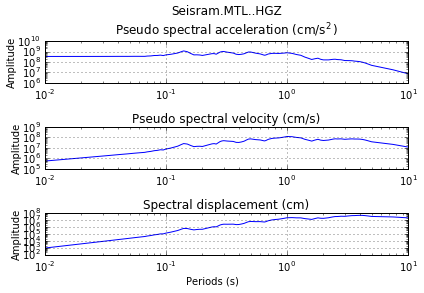

In [12]:
for tr in st_org:
    PSA, PSV, SD = ins_resp(tr.data, dt = tr.stats.delta, periods = sPeriod, xi = 0.05)
    plotting(PSA,PSV,SD,sPeriod,logplot = True,saving = 'show',title = str(tr.id))